In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [5]:
# Read
df = pd.read_csv('city_internatinal.csv')

# Basic exploration
print('Shape:', df.shape)
print('Columns:', list(df.columns))
print('\nHead:')
display(df.head())
print('\nMissing values:')
display(df.isnull().sum())
print('\nDtypes:')
display(df.dtypes)

Shape: (14538, 8)
Columns: ['Year', 'Quarter', 'City1', 'City2', 'PaxToCity2', 'PaxFromCity2', 'FreightToCity2', 'FreightFromCity2']

Head:


,Year,Quarter,City1,City2,PaxToCity2,PaxFromCity2,FreightToCity2,FreightFromCity2
0,20,2,ABHA,KOCHI,0,213,0.00,7.67
1,20,3,ABHA,KOCHI,413,0,18.73,0.00
2,15,1,ABUDHABI,AHMEDABAD,12764,15358,15.47,64.88
3,15,2,ABUDHABI,AHMEDABAD,20070,23328,74.82,162.50
4,15,3,ABUDHABI,AHMEDABAD,18134,20974,11.79,160.94



Missing values:


Year                0
Quarter             0
City1               0
City2               0
PaxToCity2          0
PaxFromCity2        0
FreightToCity2      0
FreightFromCity2    0
dtype: int64


Dtypes:


Year                  int64
Quarter               int64
City1                object
City2                object
PaxToCity2            int64
PaxFromCity2          int64
FreightToCity2      float64
FreightFromCity2    float64
dtype: object

In [6]:
# Copy for safety
df_proc = df.copy()

# Normalize column names early
df_proc.columns = df_proc.columns.str.strip().str.lower()

# Identify numeric columns
numeric_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', numeric_cols)

# Median imputation
df_proc[numeric_cols] = df_proc[numeric_cols].fillna(df_proc[numeric_cols].median())
# KNN imputation
# imputer = KNNImputer(n_neighbors=5)
# df_proc[numeric_cols] = imputer.fit_transform(df_proc[numeric_cols])

CAP_OUTLIERS = False  # set True to cap
if CAP_OUTLIERS:
    means = df_proc[numeric_cols].mean()
    stds = df_proc[numeric_cols].std(ddof=0)
    upper = means + 3*stds
    lower = means - 3*stds
    df_proc[numeric_cols] = np.minimum(df_proc[numeric_cols], upper)
    df_proc[numeric_cols] = np.maximum(df_proc[numeric_cols], lower)

Numeric columns: ['year', 'quarter', 'paxtocity2', 'paxfromcity2', 'freighttocity2', 'freightfromcity2']


In [7]:
# Ensure expected columns
expected = {'year','month','city1','city2','paxtocity2','paxfromcity2',
            'freighttocity2','freightfromcity2','mailtocity2','mailfromcity2'}
missing_expected = expected - set(df_proc.columns)
print('Missing expected columns (if any):', missing_expected)

# Clean types
if 'year' in df_proc.columns:
    df_proc['year'] = pd.to_numeric(df_proc['year'], errors='coerce').astype('Int64')
if 'month' in df_proc.columns:
    df_proc['month'] = pd.to_numeric(df_proc['month'], errors='coerce').astype('Int64')

# Date column
if {'year','month'} <= set(df_proc.columns):
    df_proc['date'] = pd.to_datetime(
        df_proc['year'].astype('Int64').astype(str) + '-' + df_proc['month'].astype('Int64').astype(str) + '-01',
        errors='coerce'
    )

# City name cleanup
for col in ['city1','city2']:
    if col in df_proc.columns:
        df_proc[col] = df_proc[col].astype(str).str.strip().str.upper()

# Standardize numeric columns into new *_scaled columns
scaler = StandardScaler()
scaled_vals = scaler.fit_transform(df_proc[numeric_cols]) if numeric_cols else None
if numeric_cols:
    for i, col in enumerate(numeric_cols):
        df_proc[col + '_scaled'] = scaled_vals[:, i]

display(df_proc.head())

Missing expected columns (if any): {'mailtocity2', 'month', 'mailfromcity2'}


,year,quarter,city1,city2,paxtocity2,paxfromcity2,freighttocity2,freightfromcity2,year_scaled,quarter_scaled,paxtocity2_scaled,paxfromcity2_scaled,freighttocity2_scaled,freightfromcity2_scaled
0,20,2,ABHA,KOCHI,0,213,0.00,7.67,0.059475,-0.406586,-0.624605,-0.611834,-0.357680,-0.441618
1,20,3,ABHA,KOCHI,413,0,18.73,0.00,0.059475,0.492280,-0.610626,-0.618740,-0.342717,-0.446757
2,15,1,ABUDHABI,AHMEDABAD,12764,15358,15.47,64.88,-1.611651,-1.305452,-0.192565,-0.120797,-0.345322,-0.403287
3,15,2,ABUDHABI,AHMEDABAD,20070,23328,74.82,162.50,-1.611651,-0.406586,0.054731,0.137609,-0.297908,-0.337881
4,15,3,ABUDHABI,AHMEDABAD,18134,20974,11.79,160.94,-1.611651,0.492280,-0.010800,0.061287,-0.348261,-0.338926


In [8]:
# Totals
def safe_sum(a, b):
    return (a.fillna(0) if a is not None else 0) + (b.fillna(0) if b is not None else 0)

if {'paxtocity2','paxfromcity2'} <= set(df_proc.columns):
    df_proc['total_passengers'] = df_proc['paxtocity2'] + df_proc['paxfromcity2']
if {'freighttocity2','freightfromcity2'} <= set(df_proc.columns):
    df_proc['total_freight'] = df_proc['freighttocity2'] + df_proc['freightfromcity2']
if {'mailtocity2','mailfromcity2'} <= set(df_proc.columns):
    df_proc['total_mail'] = df_proc['mailtocity2'] + df_proc['mailfromcity2']

# Growth % per (City1, City2) ordered by date
if {'city1','city2','date','total_passengers'} <= set(df_proc.columns):
    df_proc = df_proc.sort_values(['city1','city2','date'])
    df_proc['pax_growth_pct'] = (
        df_proc.groupby(['city1','city2'])['total_passengers']
        .pct_change()
        * 100
    )

df_proc['traffic_type'] = 'international'
display(df_proc.head())

,year,quarter,city1,city2,paxtocity2,paxfromcity2,freighttocity2,freightfromcity2,year_scaled,quarter_scaled,paxtocity2_scaled,paxfromcity2_scaled,freighttocity2_scaled,freightfromcity2_scaled,total_passengers,total_freight,traffic_type
0,20,2,ABHA,KOCHI,0,213,0.00,7.67,0.059475,-0.406586,-0.624605,-0.611834,-0.357680,-0.441618,213,7.67,international
1,20,3,ABHA,KOCHI,413,0,18.73,0.00,0.059475,0.492280,-0.610626,-0.618740,-0.342717,-0.446757,413,18.73,international
2,15,1,ABUDHABI,AHMEDABAD,12764,15358,15.47,64.88,-1.611651,-1.305452,-0.192565,-0.120797,-0.345322,-0.403287,28122,80.35,international
3,15,2,ABUDHABI,AHMEDABAD,20070,23328,74.82,162.50,-1.611651,-0.406586,0.054731,0.137609,-0.297908,-0.337881,43398,237.32,international
4,15,3,ABUDHABI,AHMEDABAD,18134,20974,11.79,160.94,-1.611651,0.492280,-0.010800,0.061287,-0.348261,-0.338926,39108,172.73,international


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If you're in a notebook
# %matplotlib inline

# Ensure date is datetime
if 'date' in df_proc.columns:
    df_proc['date'] = pd.to_datetime(df_proc['date'], errors='coerce')

# Ensure derived totals exist (defensive)
if {'paxtocity2','paxfromcity2'}.issubset(df_proc.columns):
    df_proc['total_passengers'] = df_proc['paxtocity2'].fillna(0) + df_proc['paxfromcity2'].fillna(0)
if {'freighttocity2','freightfromcity2'}.issubset(df_proc.columns):
    df_proc['total_freight'] = df_proc['freighttocity2'].fillna(0) + df_proc['freightfromcity2'].fillna(0)
if {'mailtocity2','mailfromcity2'}.issubset(df_proc.columns):
    df_proc['total_mail'] = df_proc['mailtocity2'].fillna(0) + df_proc['mailfromcity2'].fillna(0)

# Optional: sanitize growth %
if 'pax_growth_pct' in df_proc.columns:
    df_proc['pax_growth_pct'] = pd.to_numeric(df_proc['pax_growth_pct'], errors='coerce').replace([np.inf, -np.inf], np.nan)


,route,total_passengers
359,DUBAI → MUMBAI,20965013
343,DUBAI → DELHI,18377141
615,LONDON → DELHI,9548661
353,DUBAI → KOCHI,9439553
348,DUBAI → HYDERABAD,9085450
341,DUBAI → CHENNAI,8723660
126,BANGKOK → DELHI,8082127
622,LONDON → MUMBAI,7965279
338,DUBAI → BENGALURU,7188569
1006,SINGAPORE → CHENNAI,7056550


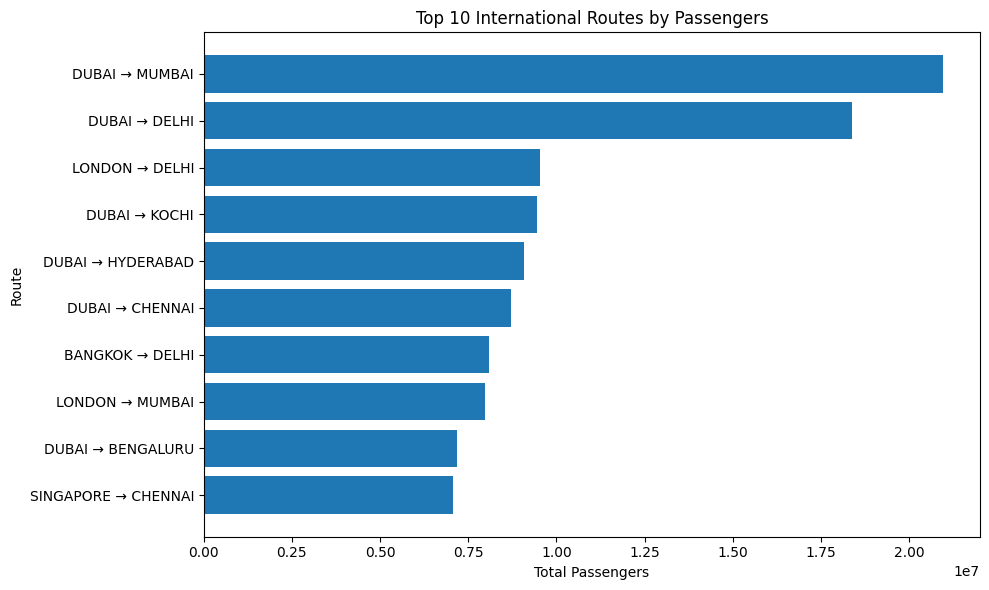

In [9]:
# Aggregate total passengers per (city1, city2)
routes = (df_proc
          .groupby(['city1', 'city2'], dropna=False)['total_passengers']
          .sum()
          .reset_index()
          .sort_values('total_passengers', ascending=False)
         )

top_routes = routes.head(10).copy()
top_routes['route'] = top_routes['city1'].astype(str) + " → " + top_routes['city2'].astype(str)

display(top_routes[['route', 'total_passengers']])

# Plot
plt.figure(figsize=(10,6))
plt.barh(top_routes['route'][::-1], top_routes['total_passengers'][::-1])
plt.title('Top 10 International Routes by Passengers')
plt.xlabel('Total Passengers')
plt.ylabel('Route')
plt.tight_layout()
plt.show()


,city1,paxfromcity2
59,DUBAI,53249401
180,SINGAPORE,19543024
1,ABUDHABI,19085572
55,DOHA,16586311
176,SHARJAH,15785152
133,MUSCAT,12768857
25,BANGKOK,12393643
108,LONDON,12283484
98,KUALALUMPUR,11303748
45,COLOMBO,9311293


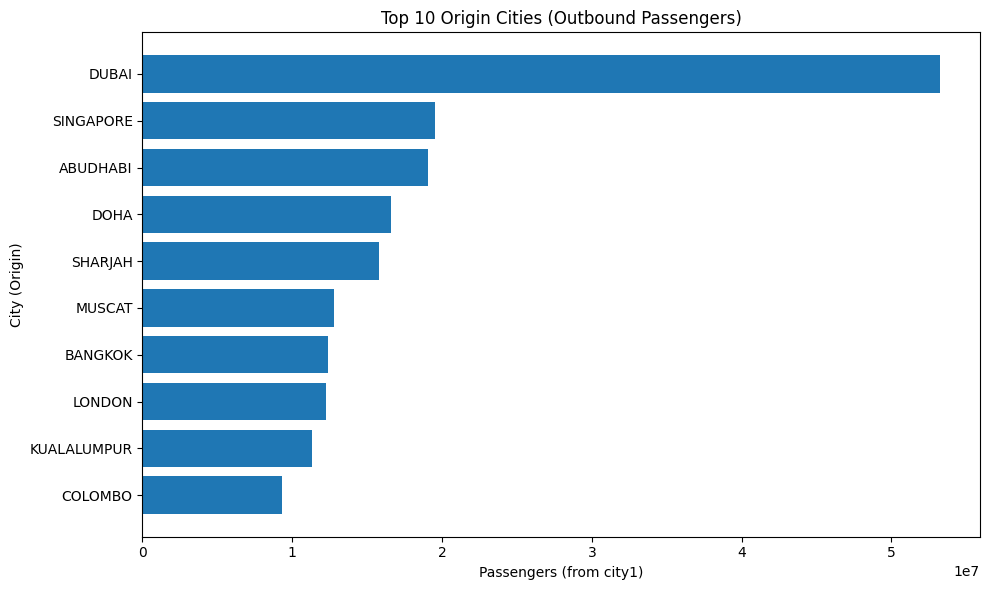

In [10]:
if 'paxfromcity2' in df_proc.columns:
    origins = (df_proc.groupby('city1', dropna=False)['paxfromcity2']
               .sum()
               .reset_index()
               .sort_values('paxfromcity2', ascending=False))
    top_origins = origins.head(10).copy()

    display(top_origins)

    # Plot
    plt.figure(figsize=(10,6))
    plt.barh(top_origins['city1'][::-1].astype(str), top_origins['paxfromcity2'][::-1])
    plt.title('Top 10 Origin Cities (Outbound Passengers)')
    plt.xlabel('Passengers (from city1)')
    plt.ylabel('City (Origin)')
    plt.tight_layout()
    plt.show()
else:
    print("Column 'paxfromcity2' not found.")


,city2,paxtocity2
23,DELHI,72442094
64,MUMBAI,52699960
19,CHENNAI,22942576
48,KOCHI,20349723
11,BENGALURU,17626420
38,HYDERABAD,16240645
50,KOZHIKODE,11545835
49,KOLKATA,9956714
93,TRIVANDRUM,9773658
1,AHMEDABAD,6145945


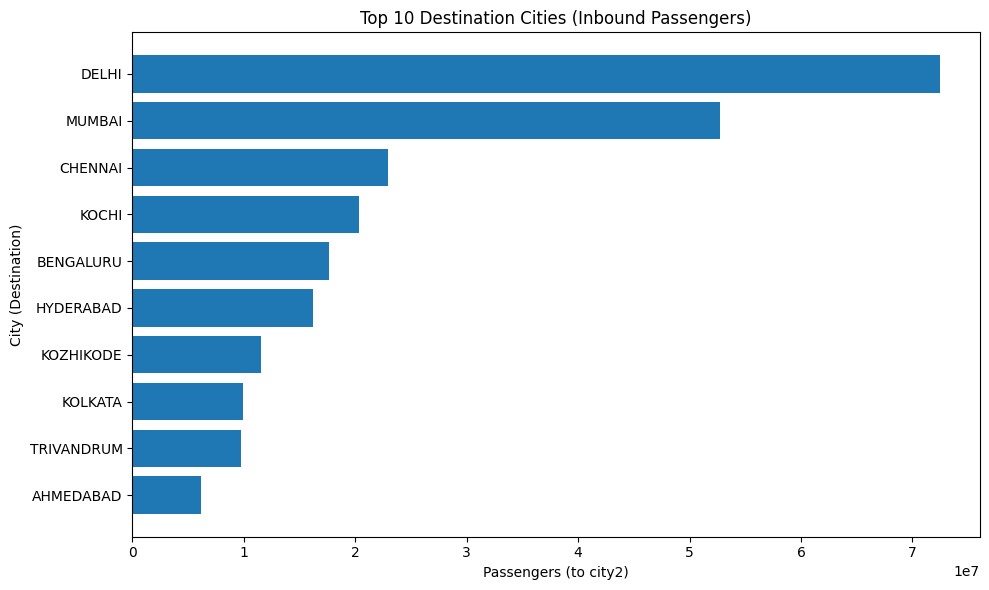

In [11]:
if 'paxtocity2' in df_proc.columns:
    destinations = (df_proc.groupby('city2', dropna=False)['paxtocity2']
                    .sum()
                    .reset_index()
                    .sort_values('paxtocity2', ascending=False))
    top_destinations = destinations.head(10).copy()

    display(top_destinations)

    # Plot
    plt.figure(figsize=(10,6))
    plt.barh(top_destinations['city2'][::-1].astype(str), top_destinations['paxtocity2'][::-1])
    plt.title('Top 10 Destination Cities (Inbound Passengers)')
    plt.xlabel('Passengers (to city2)')
    plt.ylabel('City (Destination)')
    plt.tight_layout()
    plt.show()
else:
    print("Column 'paxtocity2' not found.")


In [17]:
import pandas as pd
import numpy as np

# Create a pandas Period for the quarter, then convert to a timestamp (quarter end)
df_proc['quarter_period'] = pd.PeriodIndex(
    df_proc['year'].astype(str) + 'Q' + df_proc['quarter'].astype(str),
    freq='Q'
)
df_proc['date'] = df_proc['quarter_period'].dt.to_timestamp(how='end')  # e.g., 2024Q3 -> 2024-09-30

# Optional readable label
df_proc['year_quarter'] = df_proc['year'].astype(str) + ' Q' + df_proc['quarter'].astype(str)


In [18]:
# Ensure totals exist defensively
if {'paxtocity2','paxfromcity2'}.issubset(df_proc.columns):
    df_proc['total_passengers'] = df_proc['paxtocity2'].fillna(0) + df_proc['paxfromcity2'].fillna(0)
if {'freighttocity2','freightfromcity2'}.issubset(df_proc.columns):
    df_proc['total_freight'] = df_proc['freighttocity2'].fillna(0) + df_proc['freightfromcity2'].fillna(0)

# Sort and compute quarter-over-quarter growth per (city1, city2)
df_proc = df_proc.sort_values(['city1','city2','date'])
df_proc['pax_growth_pct'] = (
    df_proc.groupby(['city1','city2'])['total_passengers']
           .pct_change() * 100
)


,year,total_passengers
0,15,49061607
1,16,53888491
2,17,59182829
3,18,63460490
4,19,64257554
5,20,17242316
6,21,17050384
7,22,47196046
8,23,63907817
9,24,72209883


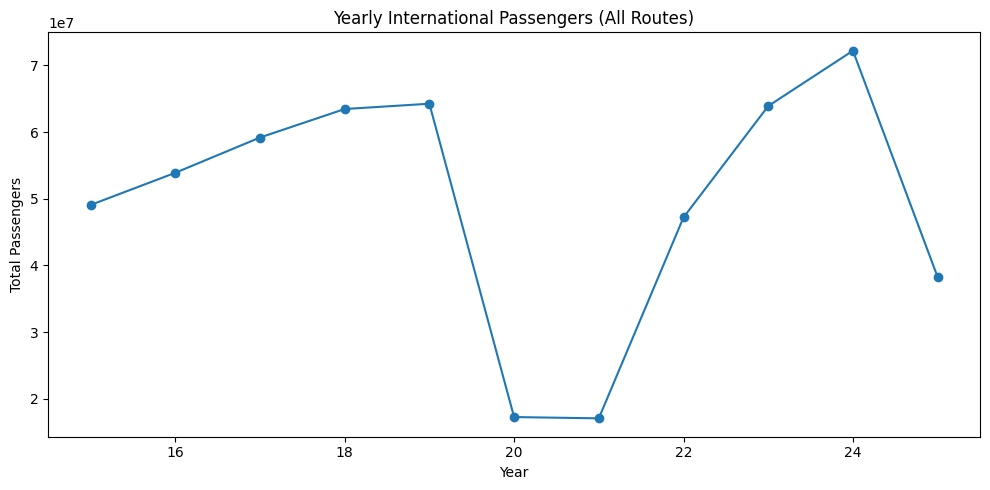

In [19]:
yearly = (df_proc.groupby('year', dropna=False)['total_passengers']
          .sum()
          .reset_index()
          .sort_values('year'))

display(yearly)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(yearly['year'], yearly['total_passengers'], marker='o')
plt.title('Yearly International Passengers (All Routes)')
plt.xlabel('Year')
plt.ylabel('Total Passengers')
plt.tight_layout()
plt.show()


,date,total_passengers
0,2015-03-31 23:59:59.999999999,12198261
1,2015-06-30 23:59:59.999999999,12269804
2,2015-09-30 23:59:59.999999999,11892081
3,2015-12-31 23:59:59.999999999,12701461
4,2016-03-31 23:59:59.999999999,13287212


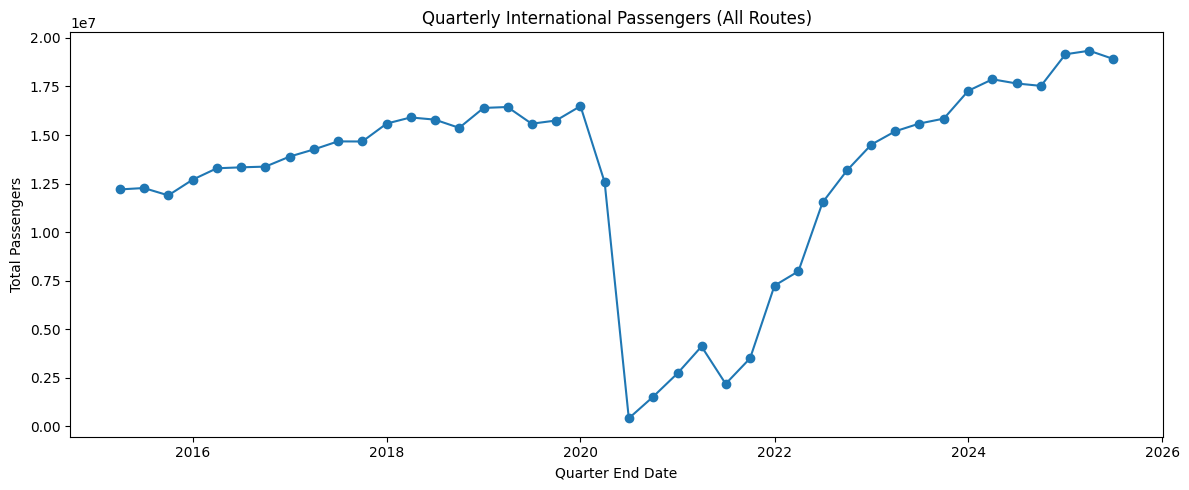

In [20]:
quarterly = (df_proc.groupby('date', dropna=False)['total_passengers']
             .sum()
             .reset_index()
             .sort_values('date'))

display(quarterly.head())

plt.figure(figsize=(12,5))
plt.plot(quarterly['date'], quarterly['total_passengers'], marker='o')
plt.title('Quarterly International Passengers (All Routes)')
plt.xlabel('Quarter End Date')
plt.ylabel('Total Passengers')
plt.tight_layout()
plt.show()


In [16]:
df_proc.columns.tolist()


['year',
 'quarter',
 'city1',
 'city2',
 'paxtocity2',
 'paxfromcity2',
 'freighttocity2',
 'freightfromcity2',
 'year_scaled',
 'quarter_scaled',
 'paxtocity2_scaled',
 'paxfromcity2_scaled',
 'freighttocity2_scaled',
 'freightfromcity2_scaled',
 'total_passengers',
 'total_freight',
 'traffic_type']

,total_passengers,total_freight,pax_growth_pct
total_passengers,1.000000,0.647049,-0.010697
total_freight,0.647049,1.000000,-0.009262
pax_growth_pct,-0.010697,-0.009262,1.000000


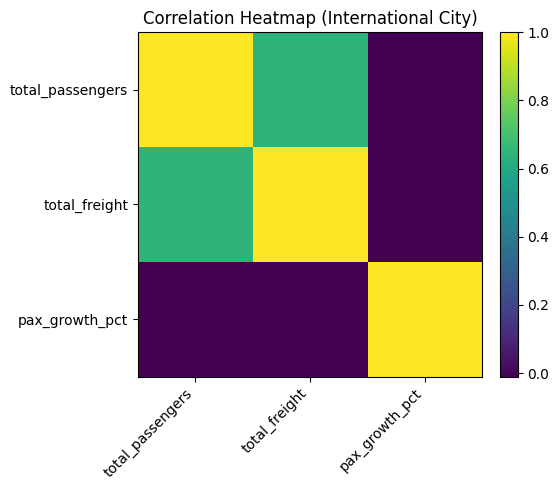

In [22]:
num_cols = [c for c in ['total_passengers','total_freight','pax_growth_pct']
            if c in df_proc.columns]

if len(num_cols) >= 2:
    corr = df_proc[num_cols].corr()
    display(corr)

    plt.figure(figsize=(6,5))
    im = plt.imshow(corr.values)
    plt.title('Correlation Heatmap (International City)')
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
    plt.yticks(range(len(num_cols)), num_cols)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for correlation:", num_cols)


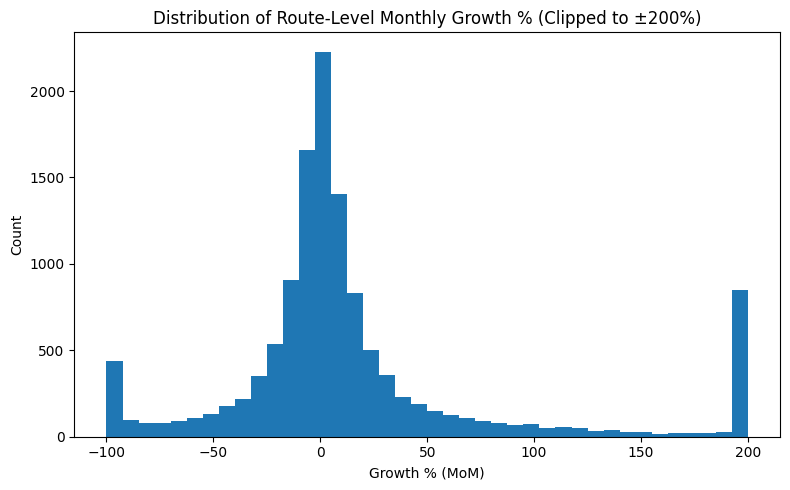

In [23]:
if 'pax_growth_pct' in df_proc.columns:
    s = df_proc['pax_growth_pct'].dropna().clip(-200, 200)  # clip extreme tails for readability

    plt.figure(figsize=(8,5))
    plt.hist(s, bins=40)
    plt.title('Distribution of Route-Level Monthly Growth % (Clipped to ±200%)')
    plt.xlabel('Growth % (MoM)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


In [24]:
out_path = "international_city_cleaned.csv"
df_proc.to_csv(out_path, index=False)
print(f"Saved: {out_path}")


Saved: international_city_cleaned.csv
